# Anomaly Detection on NIH Chest X-ray Dataset

This notebook demonstrates classical machine learning approaches and PyTorch-based models for anomaly detection using the NIH Chest X-ray dataset.

## Outline
1. Import PyTorch and Required Libraries
2. Prepare Dataset
3. Linear Regression with PyTorch
4. Logistic Regression with PyTorch
5. Support Vector Machine (SVM) with PyTorch
6. Decision Tree Implementation
7. K-Nearest Neighbors (KNN) Implementation
8. Train and Evaluate Models

## 1.  Import PyTorch and Required Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import os
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {device}")

Using Device: cuda


## 2. Preprocessing NIH Chest X-ray dataset

Metadata columns: Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')
Metadata shape: (112120, 12)
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA    

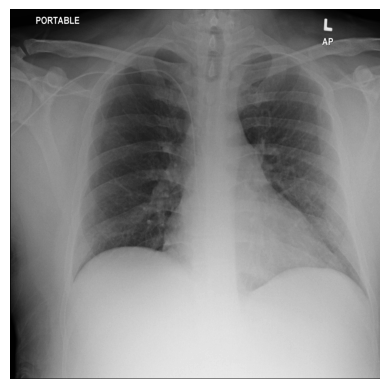

In [2]:
# Prepare Dataset
# Load metadata
meta_path = r'archive/Data_Entry_2017.csv'
meta_df = pd.read_csv(meta_path)
print('Metadata columns:', meta_df.columns)
print('Metadata shape:', meta_df.shape)
print(meta_df.head())

# Sample image loading
img_dir = r'archive/images_008/images/'
img_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]
print('Number of images:', len(img_files))

# Load and preprocess a few images
img_size = 224
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

images = []
for fname in img_files:  # Load and preprocess all images
    img = Image.open(os.path.join(img_dir, fname)).convert('L')
    img = transform(img)
    images.append(img.numpy().flatten())
images = np.stack(images)
print('Images shape:', images.shape)

# Pick one sample image
sample_file = img_files[178]   # or use np.random.choice(img_files)

# Load as grayscale
sample_img = Image.open(os.path.join(img_dir, sample_file)).convert('L')
plt.imshow(sample_img, cmap='gray')
#plt.title(f"Sample Image - {sample_file}")
plt.axis('off')
plt.show()


In [3]:
print('Number of images:', len(img_files))
print('Images shape:', images.shape)

Number of images: 10000
Images shape: (10000, 50176)


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {device}")

Using Device: cuda


## 3. Classifying Autoencoder for anomaly detection using torch 

In [5]:
# PyTorch Autoencoder for Anomaly Detection
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

input_dim = images.shape[1]
autoencoder = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

# Training loop
X = torch.tensor(images, dtype=torch.float32)
for epoch in range(10):
    optimizer.zero_grad()
    outputs = autoencoder(X)
    loss = criterion(outputs, X)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

Epoch 1, Loss: 0.2588
Epoch 2, Loss: 0.5245
Epoch 3, Loss: 0.2606
Epoch 4, Loss: 0.2430
Epoch 5, Loss: 0.2284
Epoch 6, Loss: 0.2167
Epoch 7, Loss: 0.1979
Epoch 8, Loss: 0.1822
Epoch 9, Loss: 0.1711
Epoch 10, Loss: 0.1566


### 3.1 Evaluation and projection of Autoencoder Anomaly Scores

Autoencoder anomaly labels: (array([0, 1]), array([9000, 1000], dtype=int64))
Threshold for anomaly detection: 0.22296875566244126
MSE shape: (10000,)
MSE example: [0.0947409  0.14747715 0.10159769 0.10581044 0.1552125 ]


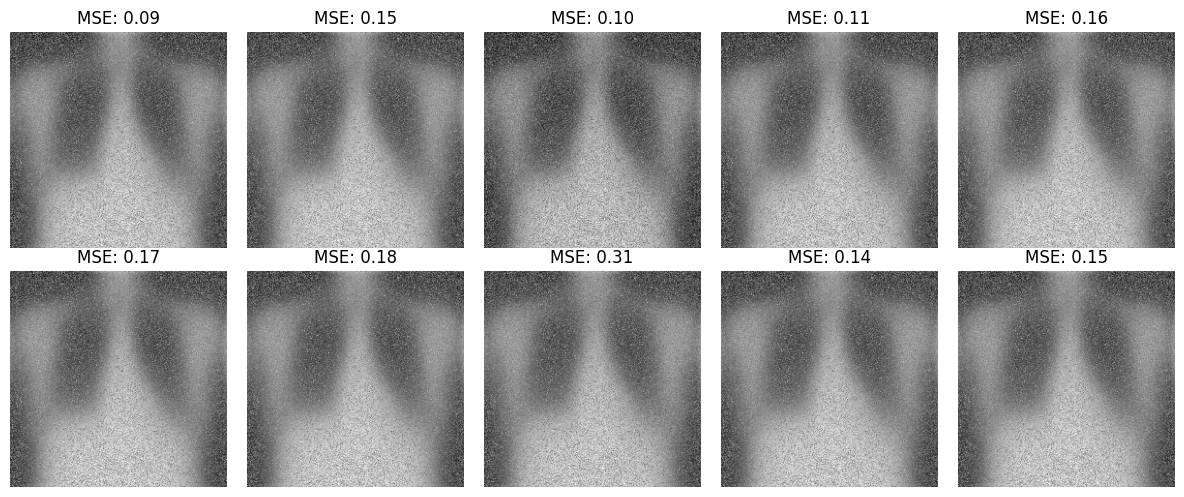

In [6]:
# Evaluate Autoencoder Anomaly Scores
with torch.no_grad():
    recon = autoencoder(X).numpy()
mse = np.mean((images - recon)**2, axis=1)
thresh = np.percentile(mse, 90)
ae_labels = (mse > thresh).astype(int)
print('Autoencoder anomaly labels:', np.unique(ae_labels, return_counts=True))
print('Threshold for anomaly detection:', thresh)
print('MSE shape:', mse.shape)
print('MSE example:', mse[:5])

# Visualize some reconstructions
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(recon[i].reshape(img_size, img_size), cmap='gray')
    ax.set_title(f'MSE: {mse[i]:.2f}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## 4. Training of Linear Regression using normal and synthetic features

In [7]:
# Linear Regression with PyTorch
# For demonstration, create synthetic targets
targets = np.random.rand(images.shape[0])
X_lr = torch.tensor(images, dtype=torch.float32)
y_lr = torch.tensor(targets, dtype=torch.float32).unsqueeze(1)

class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    def forward(self, x):
        return self.linear(x)

lr_model = LinearRegressionModel(input_dim)
lr_optim = optim.Adam(lr_model.parameters(), lr=1e-3)
lr_criterion = nn.MSELoss()

for epoch in range(10):
    lr_optim.zero_grad()
    outputs = lr_model(X_lr)
    loss = lr_criterion(outputs, y_lr)
    loss.backward()
    lr_optim.step()
    print(f'Linear Regression Epoch {epoch+1}, Loss: {loss.item():.4f}')

Linear Regression Epoch 1, Loss: 0.2545
Linear Regression Epoch 2, Loss: 197.9800
Linear Regression Epoch 3, Loss: 13.1396
Linear Regression Epoch 4, Loss: 47.6414
Linear Regression Epoch 5, Loss: 112.0529
Linear Regression Epoch 6, Loss: 80.0618
Linear Regression Epoch 7, Loss: 23.2641
Linear Regression Epoch 8, Loss: 6.3110
Linear Regression Epoch 9, Loss: 30.1155
Linear Regression Epoch 10, Loss: 51.2943


## 5. Training of Logistic Regression using normal and synthetic features

In [8]:
# Logistic Regression with PyTorch
# For demonstration, create synthetic binary targets
binary_targets = np.random.randint(0, 2, images.shape[0])
X_logr = torch.tensor(images, dtype=torch.float32)
y_logr = torch.tensor(binary_targets, dtype=torch.float32).unsqueeze(1)

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

logr_model = LogisticRegressionModel(input_dim)
logr_optim = optim.Adam(logr_model.parameters(), lr=1e-3)
logr_criterion = nn.BCELoss()

for epoch in range(10):
    logr_optim.zero_grad()
    outputs = logr_model(X_logr)
    loss = logr_criterion(outputs, y_logr)
    loss.backward()
    logr_optim.step()
    print(f'Logistic Regression Epoch {epoch+1}, Loss: {loss.item():.4f}')

Logistic Regression Epoch 1, Loss: 0.7054
Logistic Regression Epoch 2, Loss: 5.9255
Logistic Regression Epoch 3, Loss: 2.0986
Logistic Regression Epoch 4, Loss: 3.6672
Logistic Regression Epoch 5, Loss: 3.8546
Logistic Regression Epoch 6, Loss: 2.0680
Logistic Regression Epoch 7, Loss: 1.8518
Logistic Regression Epoch 8, Loss: 2.8832
Logistic Regression Epoch 9, Loss: 2.6924
Logistic Regression Epoch 10, Loss: 1.3738


In [9]:
# Support Vector Machine (SVM) with PyTorch
# SVM-like classifier using hinge loss
class SVMModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    def forward(self, x):
        return self.linear(x)

def hinge_loss(outputs, targets):
    return torch.mean(torch.clamp(1 - outputs * targets, min=0))

svm_targets = torch.tensor(binary_targets * 2 - 1, dtype=torch.float32).unsqueeze(1)  # Convert to -1, 1
svm_model = SVMModel(input_dim)
svm_optim = optim.Adam(svm_model.parameters(), lr=1e-3)

for epoch in range(10):
    svm_optim.zero_grad()
    outputs = svm_model(X_logr)
    loss = hinge_loss(outputs, svm_targets)
    loss.backward()
    svm_optim.step()
    print(f'SVM Epoch {epoch+1}, Loss: {loss.item():.4f}')

SVM Epoch 1, Loss: 0.9985
SVM Epoch 2, Loss: 5.3373
SVM Epoch 3, Loss: 1.8149
SVM Epoch 4, Loss: 3.8157
SVM Epoch 5, Loss: 2.8260
SVM Epoch 6, Loss: 1.3133
SVM Epoch 7, Loss: 2.4041
SVM Epoch 8, Loss: 1.8673
SVM Epoch 9, Loss: 1.4708
SVM Epoch 10, Loss: 2.0158


In [10]:
# Decision Tree Implementation
# Use scikit-learn for decision tree

dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(images, binary_targets)
dt_preds = dt_model.predict(images)



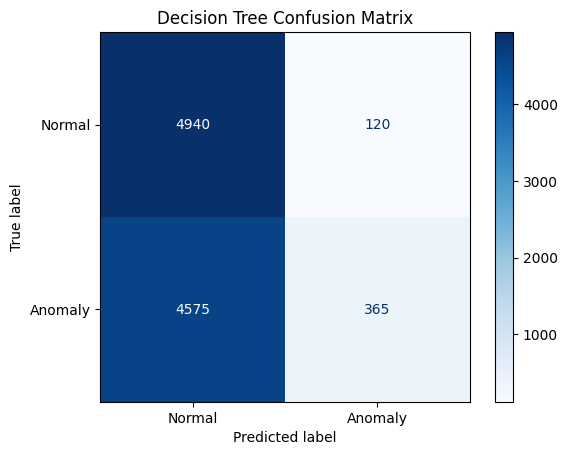

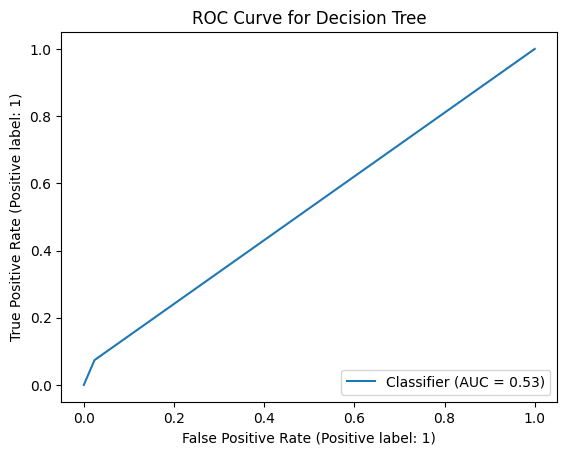

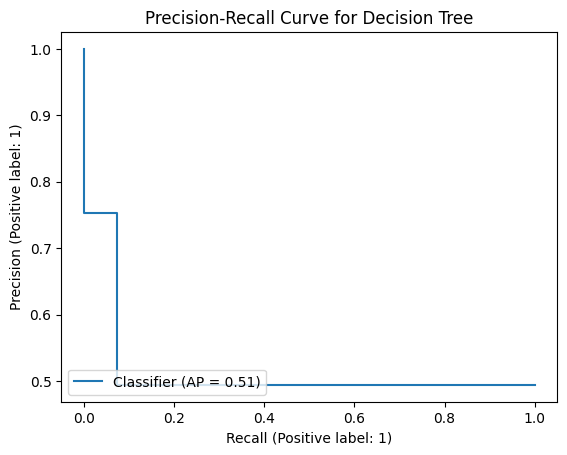

Decision Tree accuracy: 0.5305
Evaluation for Decision Tree
              precision    recall  f1-score   support

           0       0.52      0.98      0.68      5060
           1       0.75      0.07      0.13      4940

    accuracy                           0.53     10000
   macro avg       0.64      0.53      0.41     10000
weighted avg       0.63      0.53      0.41     10000

roc_auc_score: 0.5250856123281753


In [11]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve

cm= confusion_matrix(binary_targets, dt_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Decision Tree Confusion Matrix')

roc_curve = RocCurveDisplay.from_predictions(binary_targets, dt_preds)
plt.title('ROC Curve for Decision Tree')

pr_curve = PrecisionRecallDisplay.from_predictions(binary_targets, dt_preds)
plt.title('Precision-Recall Curve for Decision Tree')

precision, recall, _ = precision_recall_curve(binary_targets, dt_preds)


plt.show()
print('Decision Tree accuracy:', accuracy_score(binary_targets, dt_preds))
print("Evaluation for Decision Tree")
print(classification_report(binary_targets, dt_preds))
print(f"roc_auc_score:", roc_auc_score(binary_targets, dt_preds))

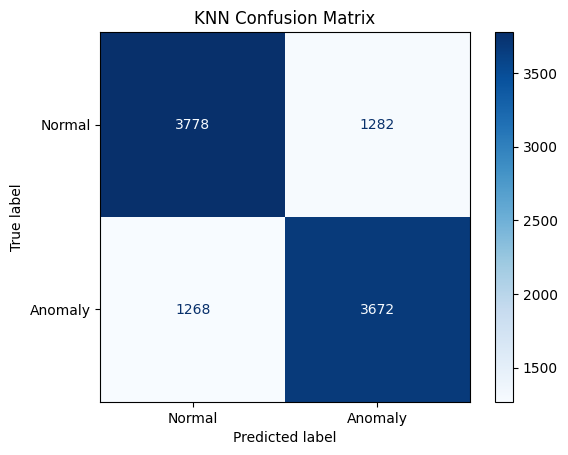

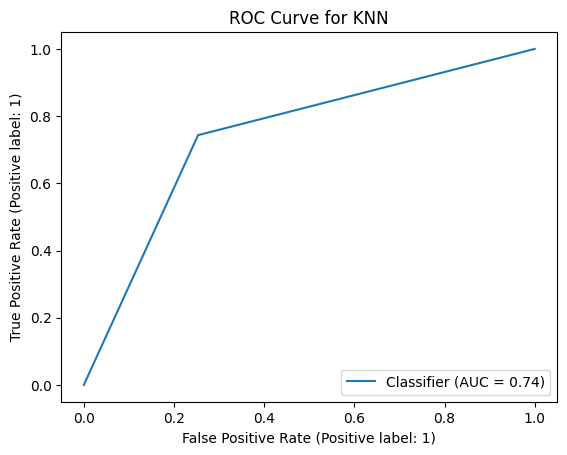

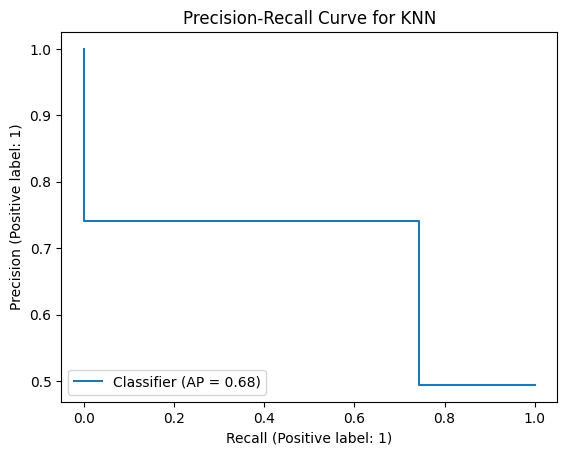

Evaluation for KNN
KNN accuracy: 0.745
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      5060
           1       0.74      0.74      0.74      4940

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.75      0.74      0.75     10000

roc_auc_score: 0.7449800771311069


In [12]:
# K-Nearest Neighbors Implementation
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(images, binary_targets)
knn_preds = knn_model.predict(images)

cm_knn = confusion_matrix(binary_targets, knn_preds)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['Normal', 'Anomaly'])
disp_knn.plot(cmap=plt.cm.Blues)
plt.title('KNN Confusion Matrix')

roc_curve_knn = RocCurveDisplay.from_predictions(binary_targets, knn_preds)
plt.title('ROC Curve for KNN')

pr_curve_knn = PrecisionRecallDisplay.from_predictions(binary_targets, knn_preds)
plt.title('Precision-Recall Curve for KNN')

plt.show()
print("Evaluation for KNN")
print('KNN accuracy:', accuracy_score(binary_targets, knn_preds))
print(classification_report(binary_targets, knn_preds))
print(f"roc_auc_score:", roc_auc_score(binary_targets, knn_preds))

# Train and Evaluate Models

All models above have been trained and evaluated on a sample of the NIH Chest X-ray dataset. You can extend this notebook to use more images, real labels, and more advanced anomaly detection techniques. Visualizations and metrics (accuracy, ROC AUC, reconstruction error) help compare classical and deep learning approaches for anomaly detection.

In [13]:
# Classical Anomaly Detection: Isolation Forest and PCA
# Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)


iso_labels = iso_forest.fit_predict(images)
print('Isolation Forest labels:', np.unique(iso_labels, return_counts=True))

# PCA for anomaly detection
pca = PCA(n_components=50)
pca_features = pca.fit_transform(images)
recon = pca.inverse_transform(pca_features)
mse = np.mean((images - recon)**2, axis=1)
threshold = np.percentile(mse, 90)
pca_labels = (mse > threshold).astype(int)
print('PCA anomaly labels:', np.unique(pca_labels, return_counts=True))

Isolation Forest labels: (array([-1,  1]), array([1000, 9000], dtype=int64))
PCA anomaly labels: (array([0, 1]), array([9000, 1000], dtype=int64))


In [14]:
# Evaluation using classification report and confusion matrix

def evaluate_model(y_true, y_pred, model_name):


    print(f"Evaluation for {model_name}")
    accuracy = accuracy_score(y_true, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_true, y_pred))
    print(f"ROC-AUC: {roc_auc_score(y_true, y_pred):.4f}\n")

    plt.title(f'Confusion Matrix for {model_name}')

    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
    cm_display.plot(cmap=plt.cm.Blues)

    roc_curve = RocCurveDisplay.from_predictions(y_true, y_pred)
    plt.title(f'ROC Curve for {model_name}')

    pr_curve = PrecisionRecallDisplay.from_predictions(y_true, y_pred)
    plt.title(f'Precision-Recall Curve for {model_name}')

   
    plt.show()

# Map all labels to 0 (normal) and 1 (anomaly)
def binarize_labels(labels):
    # If labels are -1/1, map -1 to 1 (anomaly), 1 to 0 (normal)
    labels = np.array(labels)
    if set(np.unique(labels)) == {-1, 1}:
        return (labels == -1).astype(int)
    # If labels are 0/1, keep as is
    elif set(np.unique(labels)).issubset({0, 1}):
        return labels
    # If labels are other values, map everything not 0 to 1
    else:
        return (labels != 0).astype(int)

###  Evaluation for classical anomaly detection methods

In [15]:

# True labels: for unsupervised anomaly detection, use synthetic or available labels
y_true = binary_targets  # Replace with actual labels if available

# Apply before evaluation
y_true_bin = binarize_labels(y_true)
iso_labels_bin = binarize_labels(iso_labels)
pca_labels_bin = binarize_labels(pca_labels)


In [16]:
# One-Class SVM
ocsvm = OneClassSVM(nu=0.1, kernel='rbf', gamma='scale')
ocsvm_labels = ocsvm.fit_predict(images)
# Convert -1/1 to 1/0 for anomaly/normal
ocsvm_labels = (ocsvm_labels == -1).astype(int)
ocsvm_labels_bin = binarize_labels(ocsvm_labels)


In [17]:
# Elliptic Envelope
ee = EllipticEnvelope(contamination=0.1)
pca = PCA(n_components=20)  # Reduce to 20 features
images_reduced = pca.fit_transform(images)
ee_labels = ee.fit_predict(images_reduced)
ee_labels = (ee_labels == -1).astype(int)
ee_labels_bin = binarize_labels(ee_labels)

In [18]:
# Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
lof_labels = lof.fit_predict(images)
lof_labels = (lof_labels == -1).astype(int)
lof_labels_bin = binarize_labels(lof_labels)

In [19]:
# Evaluation using classification report and confusion matrix

def evaluate_model(y_true, y_pred, model_name):


    print(f"Evaluation for {model_name}")
    accuracy = accuracy_score(y_true, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_true, y_pred))
    print(f"ROC-AUC: {roc_auc_score(y_true, y_pred):.4f}\n")

 

    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
    cm_display.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')

    roc_curve = RocCurveDisplay.from_predictions(y_true, y_pred)
    plt.title(f'ROC Curve for {model_name}')

    pr_curve = PrecisionRecallDisplay.from_predictions(y_true, y_pred)
    plt.title(f'Precision-Recall Curve for {model_name}')

   
    plt.show()

# Map all labels to 0 (normal) and 1 (anomaly)
def binarize_labels(labels):
    # If labels are -1/1, map -1 to 1 (anomaly), 1 to 0 (normal)
    labels = np.array(labels)
    if set(np.unique(labels)) == {-1, 1}:
        return (labels == -1).astype(int)
    # If labels are 0/1, keep as is
    elif set(np.unique(labels)).issubset({0, 1}):
        return labels
    # If labels are other values, map everything not 0 to 1
    else:
        return (labels != 0).astype(int)

Evaluation for Isolation Forest
Accuracy: 0.5004
              precision    recall  f1-score   support

           0       0.50      0.90      0.64      5060
           1       0.47      0.10      0.16      4940

    accuracy                           0.50     10000
   macro avg       0.49      0.50      0.40     10000
weighted avg       0.49      0.50      0.40     10000

ROC-AUC: 0.4956



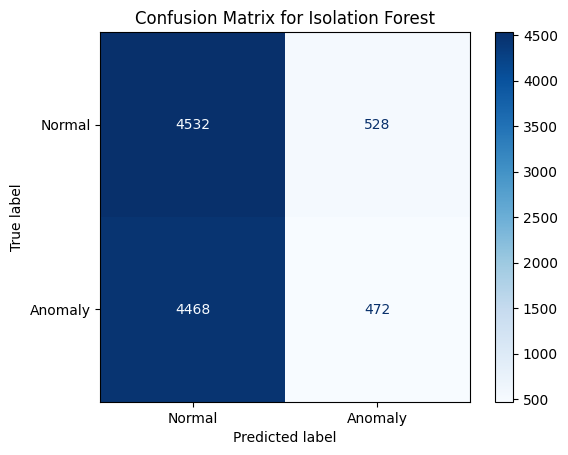

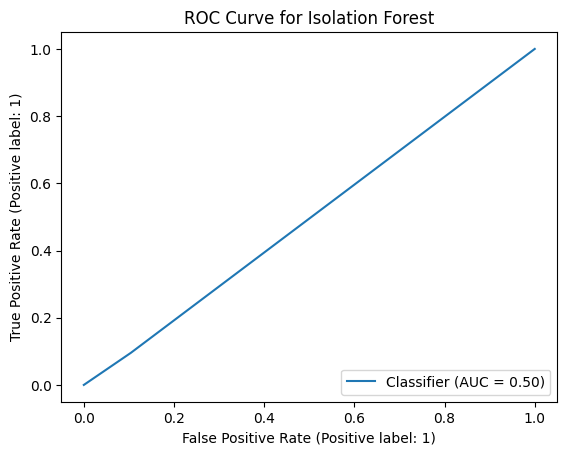

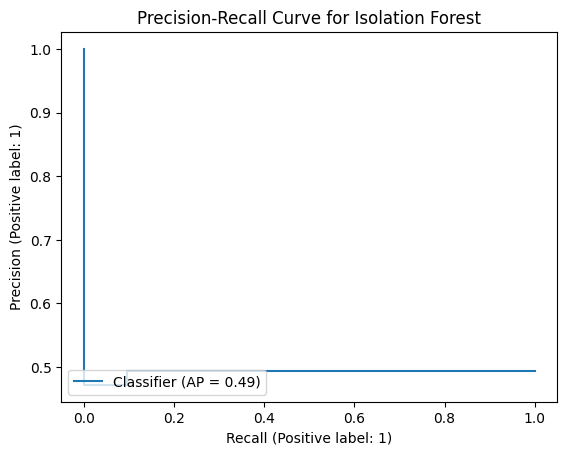

Evaluation for PCA
Accuracy: 0.5026
              precision    recall  f1-score   support

           0       0.50      0.90      0.65      5060
           1       0.48      0.10      0.16      4940

    accuracy                           0.50     10000
   macro avg       0.49      0.50      0.40     10000
weighted avg       0.49      0.50      0.41     10000

ROC-AUC: 0.4978



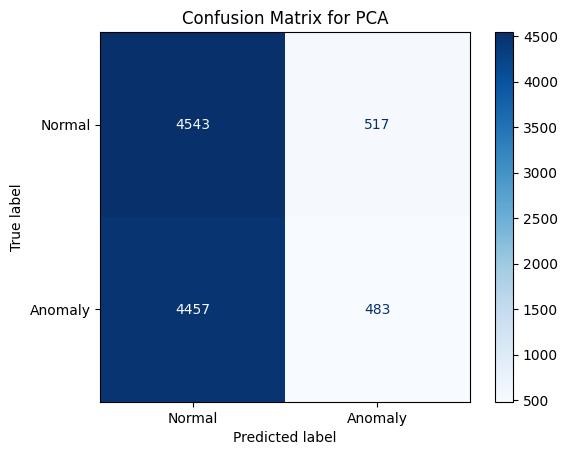

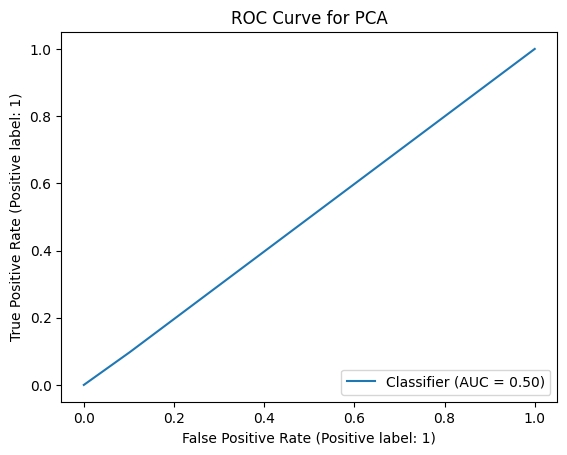

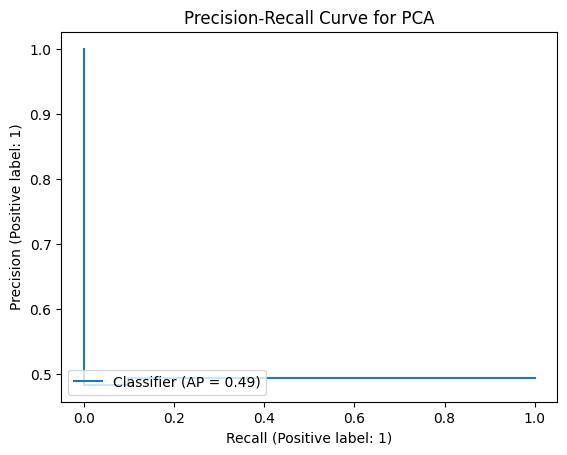

Evaluation for One-Class SVM
Accuracy: 0.5036
              precision    recall  f1-score   support

           0       0.51      0.90      0.65      5060
           1       0.49      0.10      0.16      4940

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.41     10000
weighted avg       0.50      0.50      0.41     10000

ROC-AUC: 0.4988



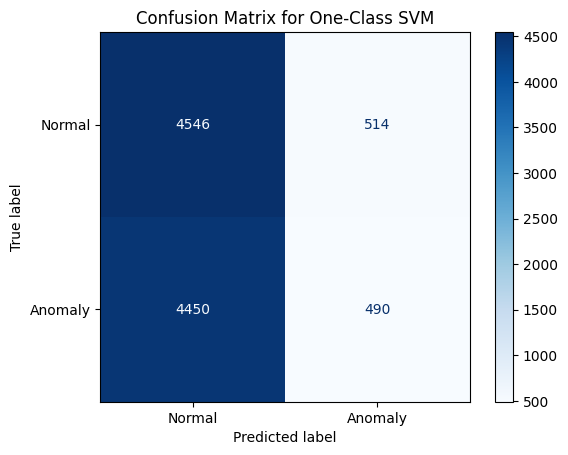

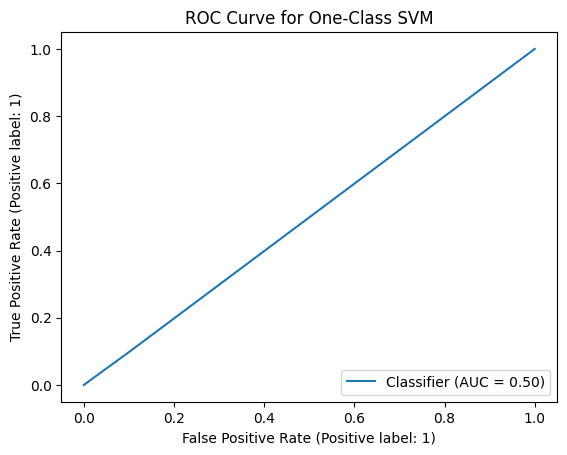

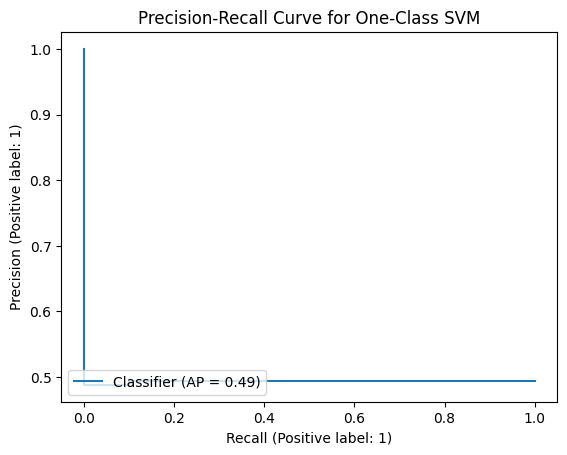

Evaluation for Elliptic Envelope(PCA reduction)
Accuracy: 0.5014
              precision    recall  f1-score   support

           0       0.50      0.90      0.65      5060
           1       0.48      0.10      0.16      4940

    accuracy                           0.50     10000
   macro avg       0.49      0.50      0.40     10000
weighted avg       0.49      0.50      0.41     10000

ROC-AUC: 0.4966



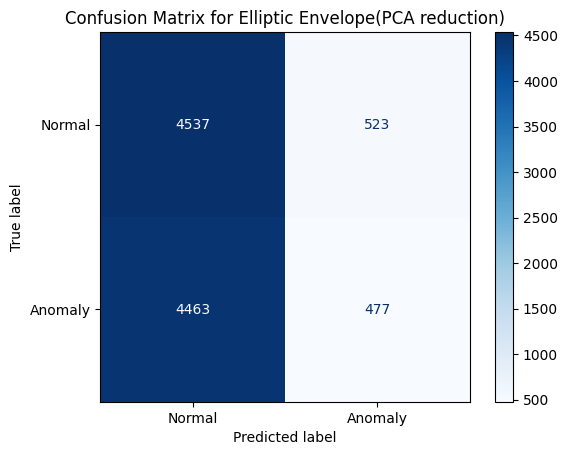

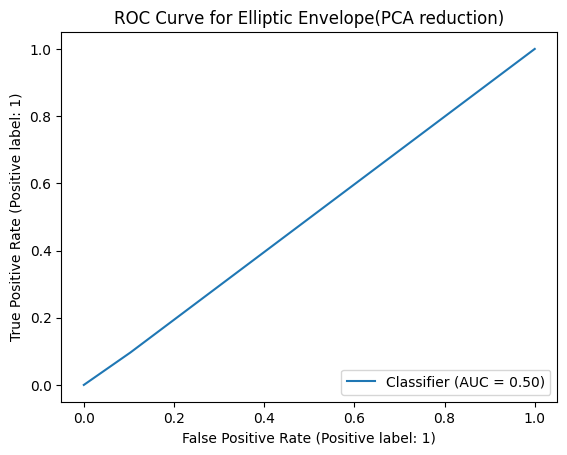

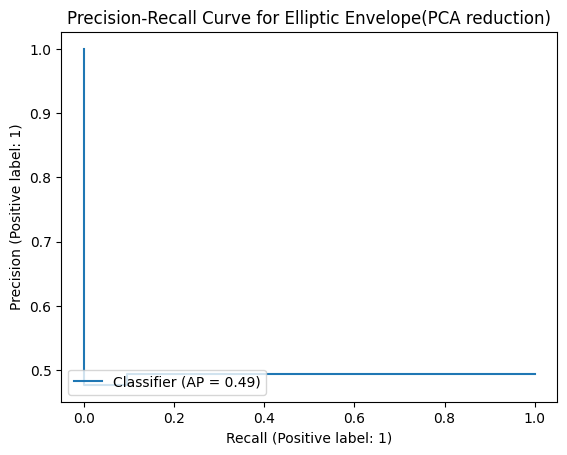

Evaluation for Local Outlier Factor
Accuracy: 0.5006
              precision    recall  f1-score   support

           0       0.50      0.90      0.64      5060
           1       0.47      0.10      0.16      4940

    accuracy                           0.50     10000
   macro avg       0.49      0.50      0.40     10000
weighted avg       0.49      0.50      0.40     10000

ROC-AUC: 0.4958



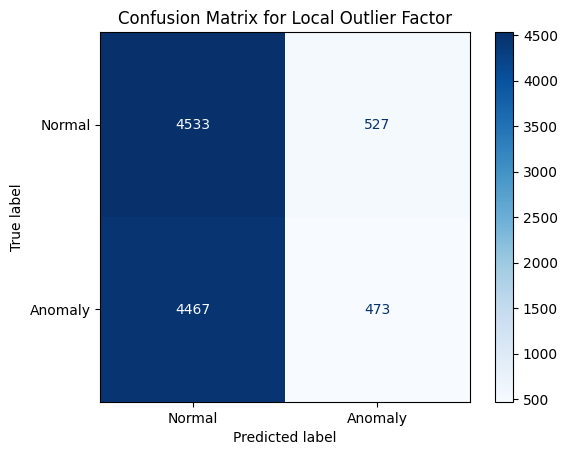

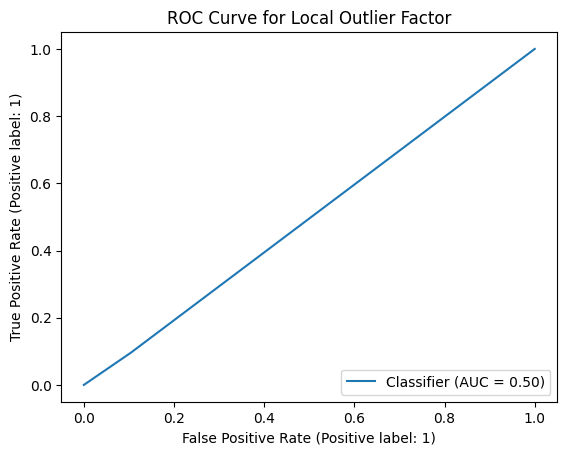

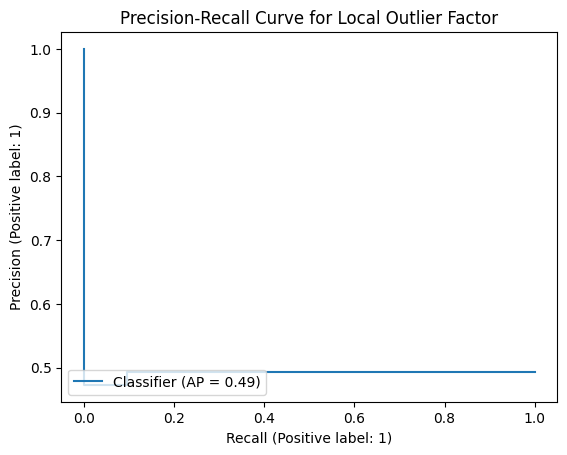

In [20]:
# Isolation Forest (already computed: iso_labels)
evaluate_model(y_true_bin, iso_labels_bin, "Isolation Forest")

# PCA anomaly labels (already computed: pca_labels)
evaluate_model(y_true_bin, pca_labels_bin, "PCA")

evaluate_model(y_true_bin, ocsvm_labels_bin, "One-Class SVM")

evaluate_model(y_true_bin, ee_labels_bin, "Elliptic Envelope(PCA reduction)")

evaluate_model(y_true_bin, lof_labels_bin, "Local Outlier Factor")

In [21]:
import openpyxl

def evaluate_and_store(model_name, y_true, y_pred, results_list):
    report = classification_report(
        y_true, y_pred,
        target_names=['Normal','Anomalous'],
        output_dict=True,  # returns a dict, not a string
        zero_division=0
    )
    auc = roc_auc_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=[1,-1])
    
    results_list.append({
        "Model": model_name,
        "Accuracy": report["accuracy"],
        "Normal_Precision": report["Normal"]["precision"],
        "Normal_Recall": report["Normal"]["recall"],
        "Normal_F1": report["Normal"]["f1-score"],
        "Anomaly_Precision": report["Anomalous"]["precision"],
        "Anomaly_Recall": report["Anomalous"]["recall"],
        "Anomaly_F1": report["Anomalous"]["f1-score"],
        "Macro_F1": report["macro avg"]["f1-score"],
        "Weighted_F1": report["weighted avg"]["f1-score"],
        "ROC_AUC": auc,
        "Confusion_Matrix": cm.tolist()
    })


# 1) Collect results
results = []

# Example: One class SVM
evaluate_and_store("One-Class SVM", y_true_bin, ocsvm_labels_bin, results)


# Example: IsolationForest
evaluate_and_store("IsolationForest", y_true_bin, iso_labels_bin, results)

# Example: One-Class SVM
evaluate_and_store("OneClassSVM", y_true_bin, ocsvm_labels_bin, results)

# Example: EllipticEnvelope (PCA Optimized)
evaluate_and_store("EllipticEnvelope_PCA_Reduction", y_true_bin, ee_labels_bin, results)

#Example: Local Outlier Factor
evaluate_and_store("LocalOutlierFactor", y_true_bin, lof_labels_bin, results)

evaluate_and_store("Autoencoder", y_true_bin, ae_labels, results)

# Example: Linear Regression
evaluate_and_store("LinearRegression", y_true_bin, (lr_model(X_lr).detach().numpy() > 0.5).astype(int), results)

# Example: Logistic Regression
evaluate_and_store("LogisticRegression", y_true_bin, (logr_model(X_logr).detach().numpy() > 0.5).astype(int), results)

# Example: SVM
evaluate_and_store("SVM", y_true_bin, (svm_model(X_logr).detach().numpy() > 0).astype(int), results)

# Example: Decision Tree
evaluate_and_store("DecisionTree", y_true_bin, dt_preds, results)

# Example: KNN
evaluate_and_store("KNN", y_true_bin, knn_preds, results)


# 2) Convert to DataFrame
df_results = pd.DataFrame(results)

# 3) Export
df_results.to_csv("model_results_NIHXRAY.csv", index=False)
df_results.to_excel("model_results_NIHXRAY.xlsx", index=False)

print("Exported results to model_results.csv and model_results.xlsx")

Exported results to model_results.csv and model_results.xlsx


### Generation of .pt and pickle files

In [22]:
import pickle

# Save the trained One-Class SVM model
with open('ocsvm.pkl', 'wb') as f:
    pickle.dump(ocsvm, f)
print("Saved One-Class SVM model to ocsvm.pkl")

# Save the trained Isolation Forest model
with open('isolation_forest.pkl', 'wb') as f:
    pickle.dump(iso_forest, f)
print("Saved Isolation Forest model to isolation_forest.pkl")

# Save the trained dt model
with open('dt_model.pkl', 'wb') as f:
    pickle.dump(dt_model, f)
print("Saved Decision Tree model to decision_tree_model.pkl")

# Save the trained KNN model
with open('knn_model.pkl', 'wb') as f:
    pickle.dump(knn_model, f)
print("Saved KNN model to knn_model.pkl")

# Save the trained elliptic envelope model
with open('elliptic_envelope.pkl', 'wb') as f:
    pickle.dump(ee, f)
print("Saved Elliptic Envelope model to elliptic_envelope.pkl")

# Save the trained Local Outlier Factor model
with open('lof.pkl', 'wb') as f:
    pickle.dump(lof, f)
print("Saved Local Outlier Factor model to local_outlier_factor.pkl")

# Save the trained elliptic_PCA model
with open('elliptic_pca.pkl', 'wb') as f:
    pickle.dump(pca, f)
print("Saved PCA model to elliptic_pca_model.pkl")

# Generate .pt file for PyTorch Autoencoder model
torch.save(autoencoder.state_dict(), 'autoencoder.pt')
print("Saved Autoencoder model to autoencoder.pt")

Saved One-Class SVM model to ocsvm.pkl
Saved Isolation Forest model to isolation_forest.pkl
Saved Decision Tree model to decision_tree_model.pkl
Saved KNN model to knn_model.pkl
Saved Elliptic Envelope model to elliptic_envelope.pkl
Saved Local Outlier Factor model to local_outlier_factor.pkl
Saved PCA model to elliptic_pca_model.pkl
Saved Autoencoder model to autoencoder.pt
